In [47]:
## import module

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
# Matplotlib for Japanese and Jupyter notebook inline 
font = {"family":"Noto Sans CJK JP"}
matplotlib.rc('font', **font)
%matplotlib inline

import os
import re

In [53]:
data = pd.read_csv('./data/raw/athlete_events.csv')
noc_data = pd.read_csv('./data/raw/noc_regions.csv')

In [49]:
gender_map = {'M':0,'F':1}

In [50]:
data['IsFEmale']=data['Sex'].map(gender_map)

In [51]:



def extract_year(val):
    year=val[:val.index(' ')]
    year=int(year)
    return year

def extract_season(val):
    season=val[val.index(' ')+1:]
    return season

data['Year']=data['Games'].apply(extract_year)
data['Season']=data['Games'].apply(extract_season)
data.drop('Games',axis=1,inplace=True)

data['Medal']=data['Medal'].fillna('None')
medal_dummies=pd.get_dummies(data['Medal'],prefix='Medal')
data=pd.concat([data,medal_dummies],axis=1)
data=data.drop('Medal',axis=1)

#for col in ['Age','Height','Weight']:
#    data[col]=data[col].fillna('NA')

event_data=[]
for ind,row in data.iterrows():
    event_data.append(re.sub(row['Sport'],'',row['Event'],count=1)[1:])
data['Event']=pd.Series(event_data,index=data.index)

print("Data Sample")
data.head()

Data Sample


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,IsFEmale,Medal_Bronze,Medal_Gold,Medal_None,Medal_Silver
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992,Summer,Barcelona,Basketball,Men's Basketball,0,0,0,1,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012,Summer,London,Judo,Men's Extra-Lightweight,0,0,0,1,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920,Summer,Antwerpen,Football,Men's Football,0,0,0,1,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Men's Tug-Of-War,0,0,1,0,0
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988,Winter,Calgary,Speed Skating,Women's 500 metres,1,0,0,1,0


In [66]:
def extract_male_female_count(data):
    gender_data=list(data.groupby(['ID','IsFEmale'])['Name'].aggregate('count').reset_index()['IsFEmale'].values)
    males=gender_data.count(0)
    females=gender_data.count(1)
    return males,females

In [69]:
# 夏季、冬季のそれぞれの男女人数を算出している
males,females=extract_male_female_count(data)
summer_data=data[data['Season']=='Summer']
winter_data=data[data['Season']=='Winter']
summer_males,summer_females=extract_male_female_count(summer_data)
winter_males,winter_females=extract_male_female_count(winter_data)

In [70]:
# 年のリストを作成している
season_year_data=data.groupby(['Year','Season'])['ID'].aggregate('count').reset_index()

summer_years=season_year_data[season_year_data['Season']=='Summer'][['Year','ID']]
winter_years=season_year_data[season_year_data['Season']=='Winter'][['Year','ID']]

min_year=min(season_year_data['Year'])
max_year=max(season_year_data['Year'])
# yearsは、開始年から直近年（２０１６）までの１年区切りのリスト（array）
years=np.arange(min_year,max_year+1)
#years から　10刻みの区間を区切る
some_years=[x for x in enumerate(years) if x[1]%10==0]

In [76]:
summer_women_repr=[]
summer_years=[]
winter_women_repr=[]
winter_years=[]
for ind,yr in enumerate(years):
    summer_year_data=summer_data[summer_data['Year']==yr]
    if(summer_year_data.shape[0]!=0):
        summer_yearly_gender_males,summer_yearly_gender_females=extract_male_female_count(summer_year_data)
        summer_women_repr.append(summer_yearly_gender_females/summer_yearly_gender_males)
        summer_years.append(yr)
    winter_year_data=winter_data[winter_data['Year']==yr]
    if(winter_year_data.shape[0]!=0):
        winter_yearly_gender_males,winter_yearly_gender_females=extract_male_female_count(winter_year_data)
        winter_women_repr.append(winter_yearly_gender_females/winter_yearly_gender_males)
        winter_years.append(yr)


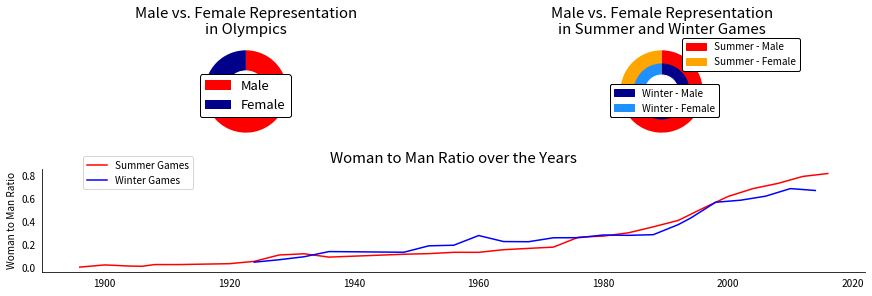

In [93]:
fig=plt.figure(figsize=(12,4),constrained_layout=True)
gs=fig.add_gridspec(2,2)
ax=[0,0,0]
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,:])

circle=plt.Circle((0,0),radius=0.5,color='white')
ax[0].pie([males,females],startangle=90,colors=['red','darkblue'],counterclock=False)
ax[0].set_title("Male vs. Female Representation\nin Olympics",fontsize=15)
ax[0].legend(['Male','Female'],loc=(0.05,0.25),facecolor='w',edgecolor='black',framealpha=1,frameon=True,fontsize=13)
ax[0].add_artist(circle)

blue=['darkblue','dodgerblue']
blue_labels=['Winter - Male','Winter - Female']
red=['red','orange']
red_labels=['Summer - Male','Summer - Female']
blue_handles=[mpatches.Patch(color=blue[i],label=blue_labels[i]) for i in [0,1]]
red_handles=[mpatches.Patch(color=red[i],label=red_labels[i]) for i in [0,1]]
circle=plt.Circle((0,0),radius=0.4,color='white')
ax[1].pie([summer_males,summer_females],radius=1,counterclock=False,colors=red,startangle=90)
ax[1].pie([winter_males,winter_females],radius=0.68,counterclock=False,colors=blue,startangle=90)
ax[1].set_title("Male vs. Female Representation\nin Summer and Winter Games",fontsize=15)
legend1=ax[1].legend(handles=red_handles,loc=(0.7,0.7),facecolor='w',framealpha=1,edgecolor='black',frameon=True)
legend2=ax[1].legend(handles=blue_handles,loc=(0,0.25),facecolor='w',framealpha=1,edgecolor='black',frameon=True)
ax[1].add_artist(legend1)
ax[1].add_artist(legend2)
ax[1].add_artist(circle)

sns.lineplot(summer_years,summer_women_repr,ax=ax[2],color='red')
sns.lineplot(winter_years,winter_women_repr,ax=ax[2],color='blue')
ax[2].set_title("Woman to Man Ratio over the Years",fontsize=15)
ax[2].set_ylabel("Woman to Man Ratio")
ax[2].legend(['Summer Games','Winter Games'],loc=(0.05,0.8))
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].tick_params(bottom=False,left=False)

plt.show()


In [94]:
summer_males

87925

In [95]:
summer_females

28851